# **207 Final Project:** NSL-KDD Network Classification Model

##### **Authors**: Samuel Berston, Claudia Flores, Jeremy Sloan

- Summary

Traditional Intrusion Detection Systems (IDS) are becoming less effective against sophisticated cyber threats, prompting the need for advanced approaches using machine learning techniques. This project aims to address this challenge by leveraging the NSL-KDD dataset and machine learning algorithms to develop a more robust IDS capable of detecting novel attack vectors and providing enhanced network security against emerging threats.

This notebook aims to show the steps we took to test our hypothesis that ML-based IDS can surpass traditional systems by enhancing anomaly detection capabilities.

The notebook has the following components:

1. Network System Design
2. Data Exploration and Feature Engineering
3. Principal Component Analysis
4. PCA Effectiveness and Bernouli Bayes Model Calibration
6. Leveraging Pytorch


- Introduction

In the evolving landscape of cybersecurity, effective network and host security are pivotal to protecting against intrusions and breaches. Traditional Intrusion Detection Systems (IDS) have long relied on static               rules and predefined patterns to identify malicious activities. However, as cyber threats become increasingly sophisticated, these systems often struggle to detect novel or evolving attack vectors that do not match established signatures. This limitation underscores the need for advanced approaches that can enhance the efficacy of intrusion detection.

Our project seeks to address this challenge by leveraging machine learning (ML) techniques to improve traditional IDS. We will utilize the NSL-KDD dataset, a well-established benchmark in cybersecurity research, to explore and implement ML-based approaches for intrusion detection. This dataset offers a rich array of network traffic attributes, including protocol types, service details, and traffic patterns, making it an ideal resource for training and evaluating ML models. By incorporating techniques such as Principal Component Analysis (PCA) for dimensionality reduction, and leveraging frameworks like PyTorch, we aim to build comprehensive pipeline for intrusion detection on a single machine within an GCP environment.

Our hypothesis is that ML-based IDS can surpass traditional systems by enhancing anomaly detection capabilities. Network protocols exhibit predictable patterns, and deviations from these patterns can be indicative of malicious activities. Machine learning algorithms, including classification models, anomaly detection, and deep neural networks, are well-suited to identifying these deviations, even when they do not conform to known attack signatures. Furthermore, ML's ability to integrate data from diverse sources—such as IP packets, host logs, and user behavior analytics—can offer a more holistic view of network activities, improving the accuracy of threat detection.

The NSL-KDD dataset will serve as the foundation for our experimentation. It provides a diverse range of network traffic attributes that facilitate the classification of network behaviors into normal or anomalous categories. Its structured improvements over the original KDD Cup 99 dataset and widespread acceptance in academic research make it a reliable choice for evaluating ML-based IDS techniques. However, we recognize potential challenges, such as the lack of packet payload data in the dataset, which could impact the detection of certain attacks. Additionally, the normalization of network data, while essential for ML analysis, must be carefully managed to preserve critical information.

Our approach involves setting up a single machine environment with GCP cloud infrastructure, Nvidia chips, and virtual machines to run PCA, pre-process data, and develop an ML-based IDS. Once the prototype is operational, we aim to scale the solution using Terraform to create a corporate network solution that supports broader deployment. This project will involve several key stages: initial setup and background research, problem description, implementation of sensible methods, feature engineering, error analysis, and documentation of results.

By advancing the capabilities of IDS through machine learning, we aspire to enhance network security and provide a more robust defense against emerging threats.

- Our Findings

The machine learning-based Intrusion Detection System (IDS) demonstrated high effectiveness, achieving 99.61% accuracy on the NSL-KDD dataset, surpassing traditional rule-based systems in detecting network anomalies. Key contributions to its performance include dimensionality reduction via PCA and the implementation of a deep learning model using PyTorch.

Deployment on GCP with Zeek enabled efficient traffic monitoring and log generation, avoiding the need for agents on VMs. The system’s practical application showcases the potential of machine learning in network intrusion detection, with logs converted to ECS format for further processing.

While the model excels in high-probability predictions, it shows weaker calibration for lower probability ranges, indicating areas for improvement. Future work should focus on refining calibration, and exploring cloud storage, log normalization, inference clients, and diverse data evaluation.

## 1. *Network* System Design Diagram

This network diagram represents the application of our model for cloud network intrusion detection. The system design is based on the blueprint from GCP's [terraform-google-network-forensics](https://github.com/GoogleCloudPlatform/terraform-google-network-forensics) project. The design uses packet mirroring along with zeek/fluentd for observability and network logging. It then uses Google's Vertex AI service to deploy the model and access it as an Endpoint.
The steps for our GCP cloud set up is documented [here](https://docs.google.com/document/d/1__LruRVeX_8sKiowL7mTMPURr3n1j9PibsBCVltd3CQ/edit?usp=sharing). We got so far as setting up the networking, managed instance groups, load balancing, packet mirroring, and installed/configured zeek/fluentd on the VMs, however we didn't have time to finish cloud storage, log normalization, inference client, and model deployment.

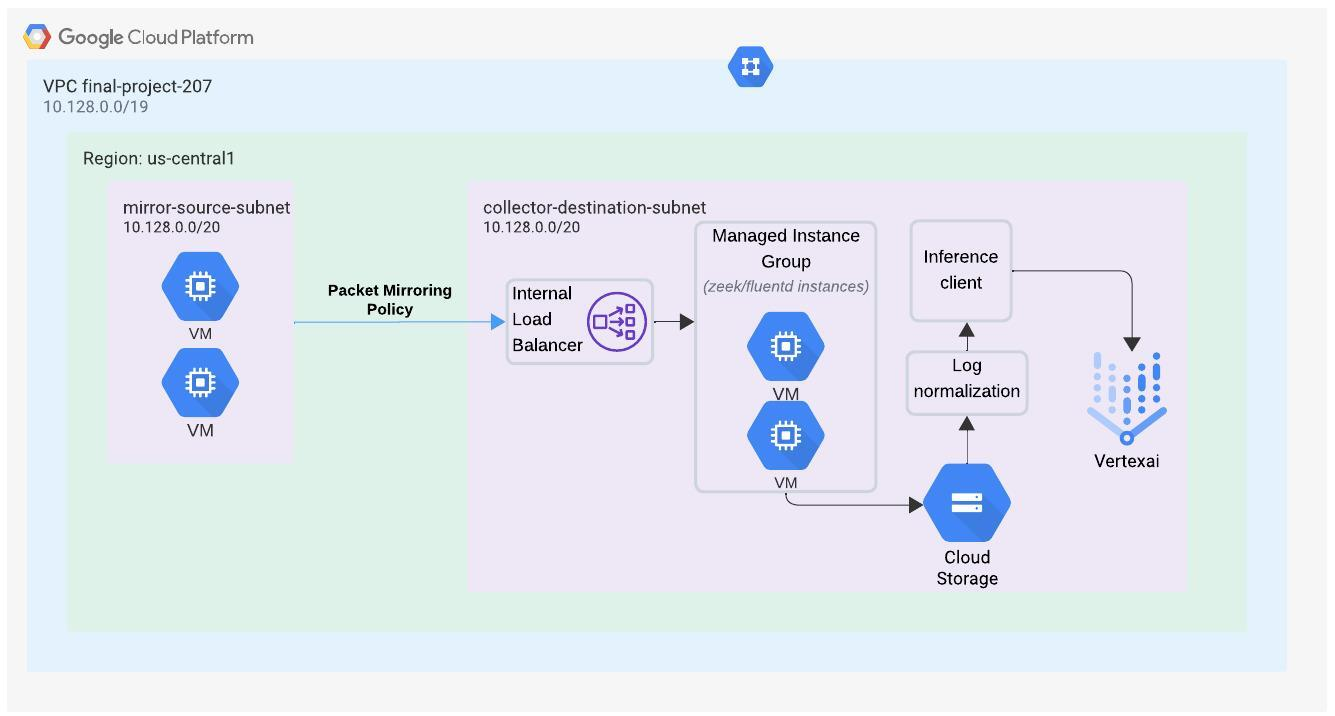

Four managed VM instances running in mirror/collector subnets:

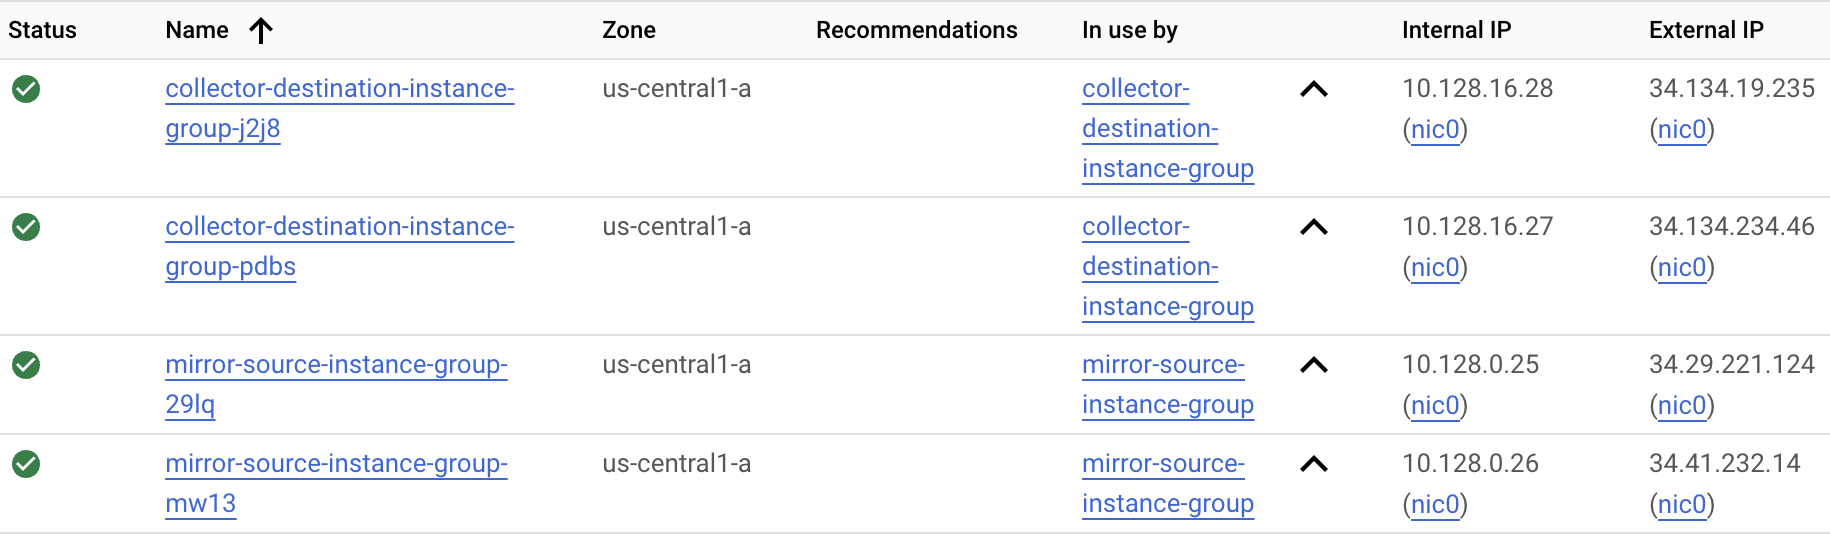

Packet mirroring policy:

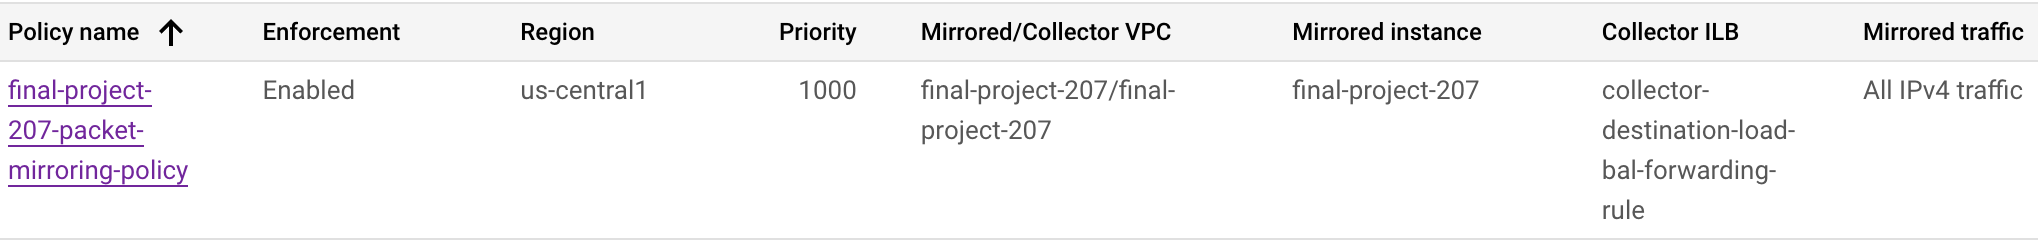

Zeek running in collector VM:

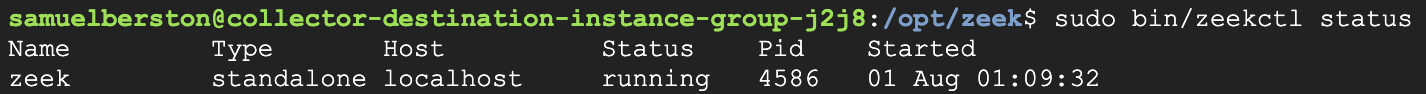

Zeek collecting logs from mirror VM instances, to give you a sense of the kind of logs zeek collects:

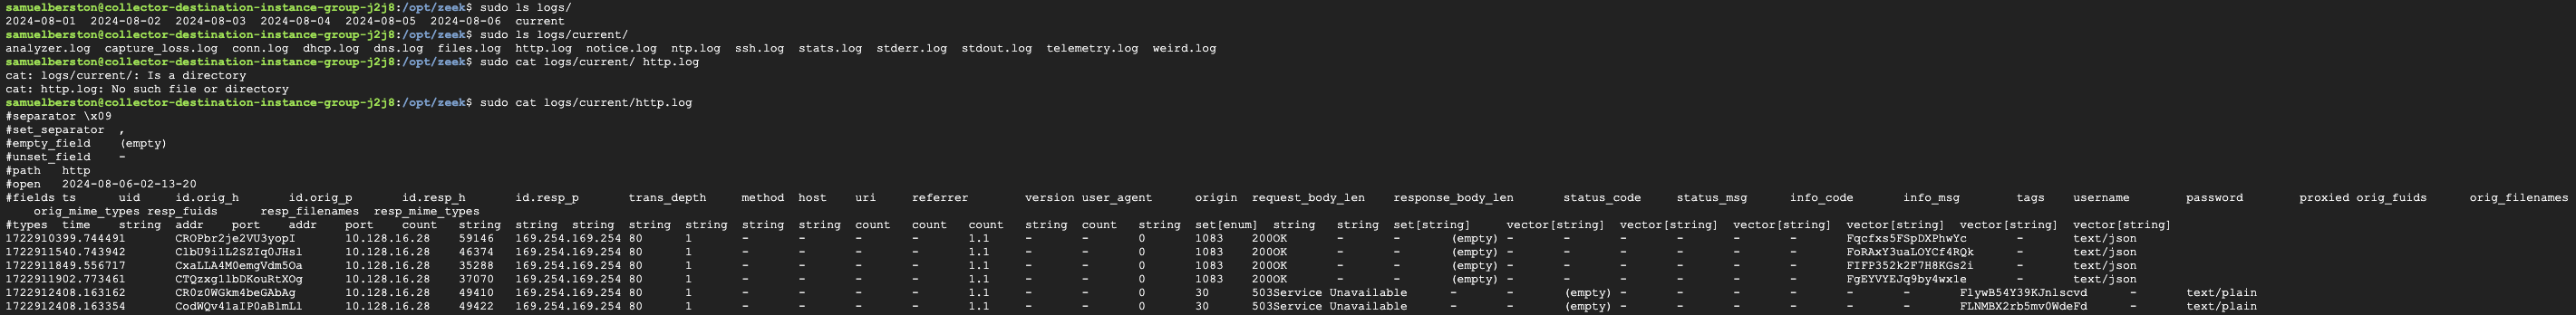

fluentd process running on VM:

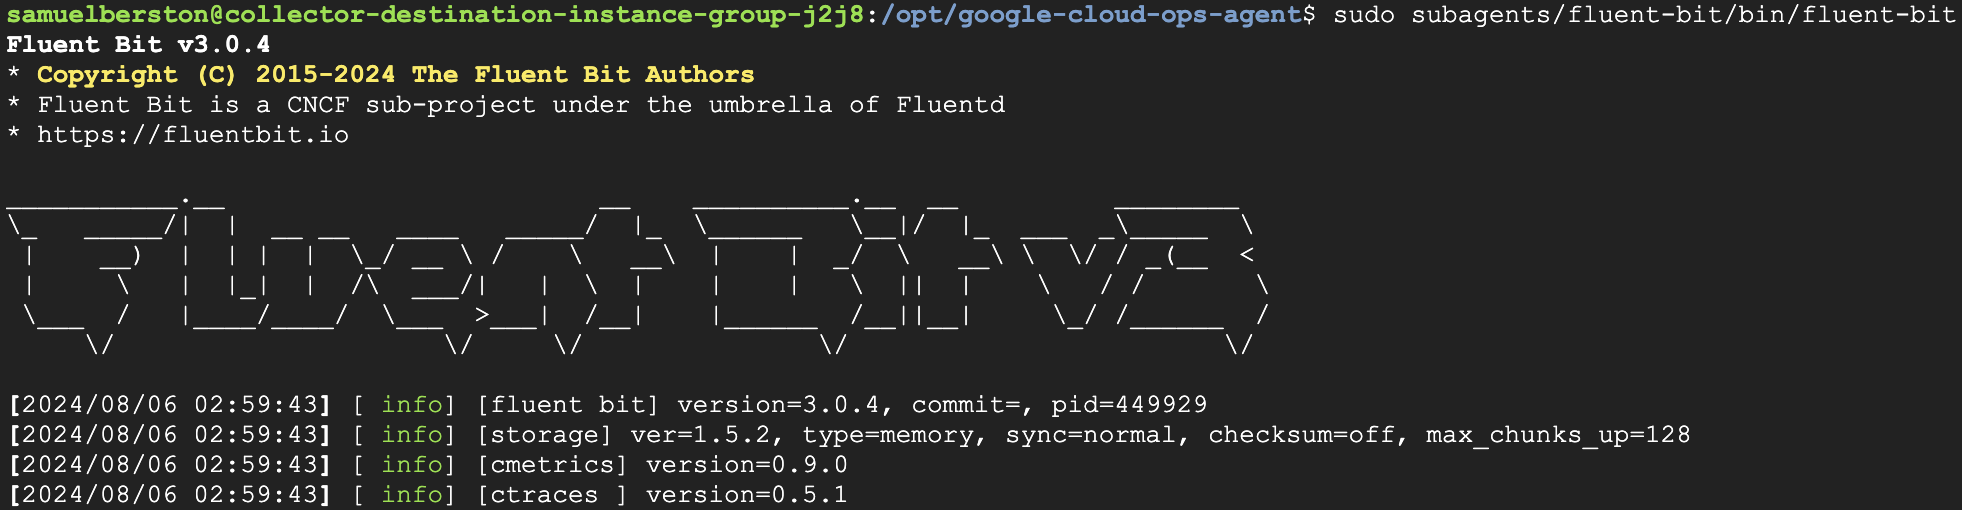

## Deploying Zeek on GCP

Deploying Zeek on Google Cloud Platform (GCP) involves a comprehensive setup process to enable effective network traffic monitoring and analysis. This includes setting up a GCP account, enabling necessary APIs, configuring a Virtual Private Cloud with appropriate subnets, and using tools like Terraform for infrastructure management. The deployment also involves setting up managed instance groups for Zeek and Fluentd, configuring load balancing, and implementing packet mirroring policies to ensure thorough traffic analysis.

The integration of Zeek with GCP and machine learning models creates a powerful platform for advanced intrusion detection. This combination leverages Zeek's real-time network analysis capabilities with the scalability and flexibility of GCP, allowing for the application of sophisticated ML techniques to detect anomalies and threats.

The enhanced monitoring and comprehensive data collection facilitated by this setup are crucial for training and validating ML models, potentially enabling the system to outperform traditional intrusion detection systems in identifying complex patterns and emerging threats.



NOTE: the cells that are taken from kaggle have been cited

### Library Imports

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression

In [ ]:
# add the column labels
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised',
'root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count',
'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
'dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])

In [ ]:
# train and test data raw github links
train_file = 'https://raw.githubusercontent.com/jmnwong/NSL-KDD-Dataset/9d544d0eb9b87d7e2f43ff65733bdb644631d12f/KDDTrain%2B.txt'
test_file = 'https://raw.githubusercontent.com/jmnwong/NSL-KDD-Dataset/9d544d0eb9b87d7e2f43ff65733bdb644631d12f/KDDTest%2B.txt'

# load data with columns
train_df = pd.read_csv(train_file, names=columns)
test_df = pd.read_csv(test_file, names=columns)

# view the data
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


## 2. Data Exploration and Feature Engineering
- dimensionality reduction - PCA
- add attack flag and attack type - https://www.kaggle.com/code/timgoodfellow/nsl-kdd-explorations#Exploring-NSL-KDD-dataset

- dealing with null/missing values
- scaling data

Data transformation - add attack flag

source: https://www.kaggle.com/code/timgoodfellow/nsl-kdd-explorations?scriptVersionId=41551168&cellId=7

In [ ]:
# map normal to 0, all attacks to 1
is_attack = train_df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)

train_df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack

# view the result
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0


Data transformation - attack classifications

source: https://www.kaggle.com/code/timgoodfellow/nsl-kdd-explorations?scriptVersionId=41551168&cellId=10

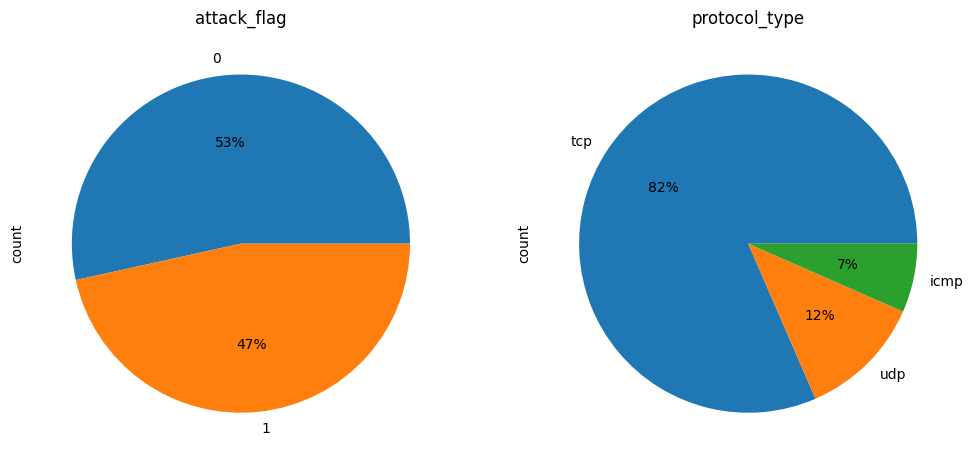

In [ ]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(12, 12), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize = 12)
    plt.show()

pie_plot(train_df, ['attack_flag', 'protocol_type'], 1, 2)

The pie charts show the distribution of attacks vs. normal traffic and the distribution of network protocols in the training dataset.  There are slightly more normal instances than attacks, and the TCP protocol is the most common.

Add feature - attack classification type

In [ ]:
# lists to hold our attack classifications
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

# we will use these for plotting below
attack_labels = ['Normal','DoS','Probe','Privilege','Access']

# helper function to pass to data frame mapping
def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks mapt to 2
        attack_type = 2
    elif attack in privilege_attacks:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in access_attacks:
        # remote access attacks map to 4
        attack_type = 4
    else:
        # normal maps to 0
        attack_type = 0
    return attack_type

# map the data and join to the data set
attack_map = train_df.attack.apply(map_attack)
train_df['attack_map'] = attack_map

test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map

# view the result
train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0,0


Fix discrepancy in su_attempted data  

source: https://colab.research.google.com/drive/1NY7_JW4r69A8wLFcj8sXpyAB2qUmwiRe?usp=sharing#scrollTo=MunLitnporc4


In [ ]:
# Fix discrepancies in the 'su_attempted' column
train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)

In [ ]:
# Check and drop 'num_outbound_cmds' column if it only has one unique value
if 'num_outbound_cmds' in train_df.columns:
    if train_df['num_outbound_cmds'].nunique() == 1:
        train_df.drop('num_outbound_cmds', axis=1, inplace=True)
        test_df.drop('num_outbound_cmds', axis=1, inplace=True)
    else:
        print("Column 'num_outbound_cmds' has more than one unique value.")

# Define features and target variable for training and test datasets
X_train = train_df.drop(['attack', 'level', 'attack_flag', 'attack_map'], axis=1)
y_train = train_df['attack_flag']

X_test = test_df.drop(['attack', 'level', 'attack_flag', 'attack_map'], axis=1)
y_test = test_df['attack_flag']

# Define categorical features
categorical_features = ['protocol_type', 'service', 'flag']

# Define the column transformer with one-hot encoding for categorical features and scaling for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.select_dtypes(include=[np.number]).columns),  # Scale numeric features
        ('cat', OneHotEncoder(), categorical_features)  # One-hot encode categorical features
    ]
)

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Transform the test data
X_test_processed = preprocessor.transform(X_test)

# Show a sample of processed data
print(X_train_processed[:5])
print(X_test_processed[:5])

[[-0.11024922 -0.0076786  -0.00491864 -0.01408881 -0.08948642 -0.00773599
  -0.09507567 -0.02702282 -0.80926182 -0.01166364 -0.03665187 -0.0129124
  -0.01238515 -0.02618002 -0.0186099  -0.0412212  -0.00281749 -0.09753094
  -0.71704549 -0.35434285 -0.63720927 -0.63192903 -0.37436224 -0.3744316
   0.77128311 -0.34968303 -0.3745597  -0.32406309 -0.81888998 -0.78236683
  -0.28028168  0.06997226 -0.2891034  -0.63953191 -0.6248708  -0.22453241
  -0.37638703  0.          1.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0. 

#### Scaling and Preprocessing

Scaling of non-categorical feature values ensures that each feature contributes equally to the model, improves algorithm performance and stability, and facilitates effective regularization and interpretation. [Source](https://www.kaggle.com/code/essammohamed4320/intrusion-detection-system-with-ml-dl).

In [ ]:
# Define features and target variable for training and test datasets
X_train = train_df.drop(['attack', 'level', 'attack_flag', 'attack_map'], axis=1)
y_train = train_df['attack_flag']

X_test = test_df.drop(['attack', 'level', 'attack_flag', 'attack_map'], axis=1)
y_test = test_df['attack_flag']

# Define categorical features
categorical_features = ['protocol_type', 'service', 'flag']

# Define the column transformer with one-hot encoding for categorical features and scaling for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.select_dtypes(include=[np.number]).columns),  # Scale numeric features
        ('cat', OneHotEncoder(), categorical_features)  # One-hot encode categorical features
    ]
)

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Transform the test data
X_test_processed = preprocessor.transform(X_test)

# Convert the processed training data back to a DataFrame
# Get the feature names after one-hot encoding
num_features = X_train.select_dtypes(include=[np.number]).columns
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(num_features) + list(cat_features)

# Convert the numpy array back to a DataFrame
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names)

# Display the head of the processed training data
X_train_processed_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,-0.110249,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.110249,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.110249,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.110249,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3. Running Principal Component Analysis (PCA)


PCA is crucial for validating our hypothesis that ML-based IDS can outperform traditional systems by enhancing anomaly detection.

- Dimensionality Reduction: Simplifies the model and improves computational efficiency by reducing the number of features while retaining key information.

- Enhanced Visualization: Allows for plotting data in 2D or 3D, helping to visualize patterns and assess class separation, which is vital for evaluating anomaly detection.

- Noise Reduction: Focuses on components that capture the most variance, minimizing the impact of noise and irrelevant features.
Feature Extraction: Reveals underlying data structures that may improve the detection of anomalies by highlighting more relevant features.

- Efficiency: Streamlines the modeling process, making it easier to identify deviations and enhance detection capabilities.

PCA improves the effectiveness and efficiency of ML-based IDS, supporting the hypothesis that advanced ML techniques can surpass traditional methods in anomaly detection.

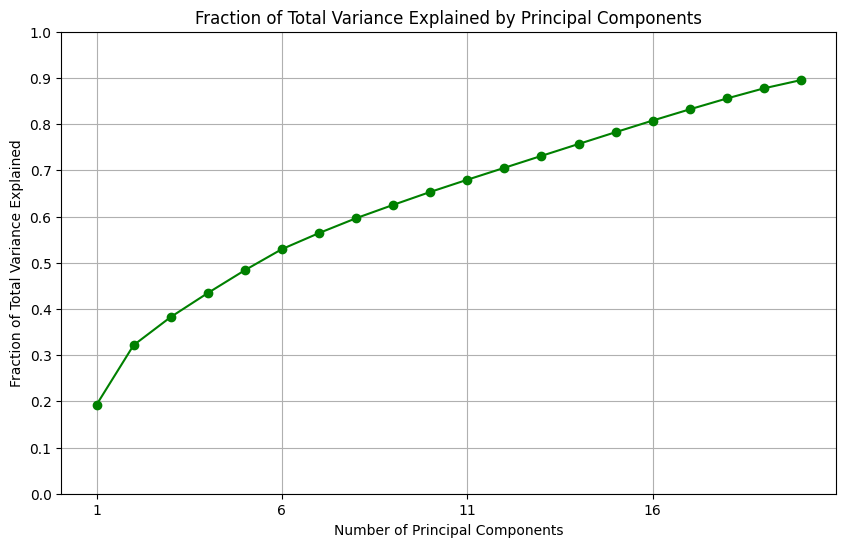

Fraction of total variance explained by the first k principal components:
k = 1: 0.192428829845544
k = 2: 0.3215289475521145
k = 3: 0.38238611712190995
k = 4: 0.43434485587882665
k = 5: 0.48376250773359264
k = 10: 0.6531691895949667
k = 20: 0.8953651830756543


In [ ]:
# Initialize PCA
pca = PCA(n_components=20)

# Fit PCA on the training data
X_train_pca = pca.fit_transform(X_train_processed)

# Transform the test data using the fitted PCA
X_test_pca = pca.transform(X_test_processed)

# Calculate variance explained by each principal component
variance_explained = pca.explained_variance_ratio_

# Compute cumulative variance explained
cum_variance_explained = np.cumsum(variance_explained)

# Plotting the fraction of total variance explained
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(variance_explained) + 1), cum_variance_explained, marker='o', linestyle='-', color='green')
plt.title('Fraction of Total Variance Explained by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Fraction of Total Variance Explained')
plt.grid(True)
plt.xticks(np.arange(1, len(variance_explained) + 1, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

k_values = [1, 2, 3, 4, 5, 10, 20]
print("Fraction of total variance explained by the first k principal components:")
for k in k_values:
    if k <= len(cum_variance_explained):
        print(f"k = {k}: {cum_variance_explained[k - 1]}")
    else:
        print(f"k = {k}: Not available (more components required)")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


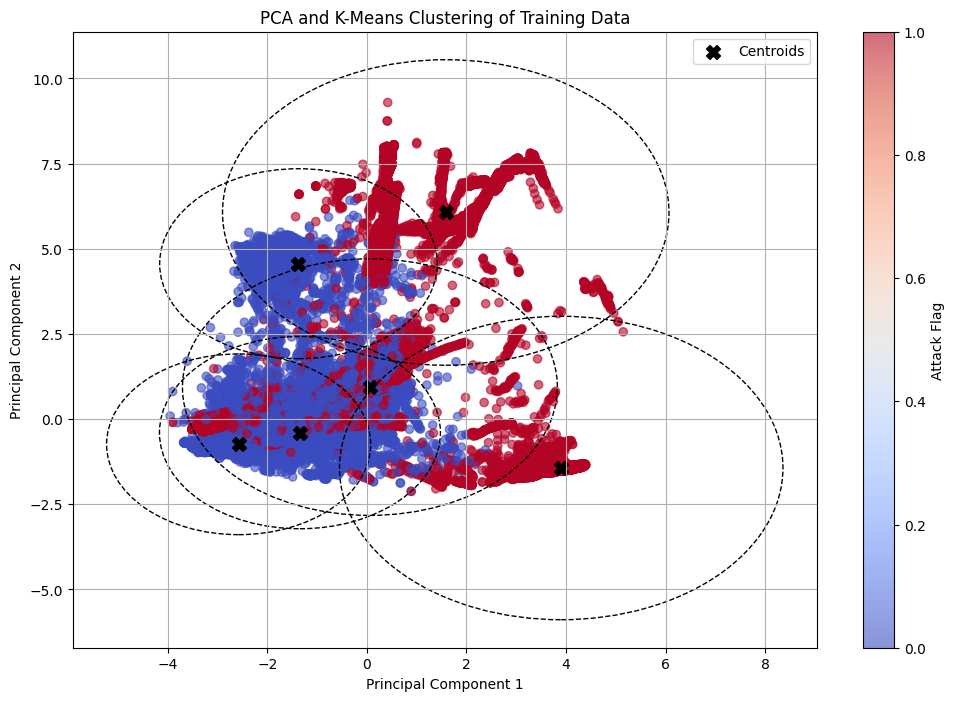

In [ ]:
# Reduce PCA to 2 components for visualization
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_processed)

# Fit k-means model
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(X_train_pca_2d)
clusters = kmeans.labels_
centroids = kmeans.cluster_centers_

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=X_train_pca_2d, columns=['PC1', 'PC2'])
pca_df['attack_flag'] = y_train.values
pca_df['cluster'] = clusters

# Plotting the PCA result
plt.figure(figsize=(12, 8))
# Plot all examples
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['attack_flag'], cmap='coolwarm', alpha=0.6, edgecolor=None)
plt.colorbar(scatter, label='Attack Flag')
# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=100, marker='X', label='Centroids')

# Plot circles around the centroids
for i, centroid in enumerate(centroids):
    cluster_points = X_train_pca_2d[clusters == i]
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    max_distance = distances.max()
    circle = plt.Circle(centroid, max_distance, color='black', fill=False, linestyle='--', linewidth=1)
    plt.gca().add_patch(circle)

plt.title('PCA and K-Means Clustering of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

This image shows a more complex visualization combining PCA with K-means clustering. The data points are again plotted using the first two principal components, but now they're colored on a gradient from blue to red, representing the likelihood of being an attack (with blue being normal and red being attack). The plot also shows several ellipses, which represent the boundaries of different clusters identified by the K-means algorithm. Black X marks indicate the centroids of these clusters.

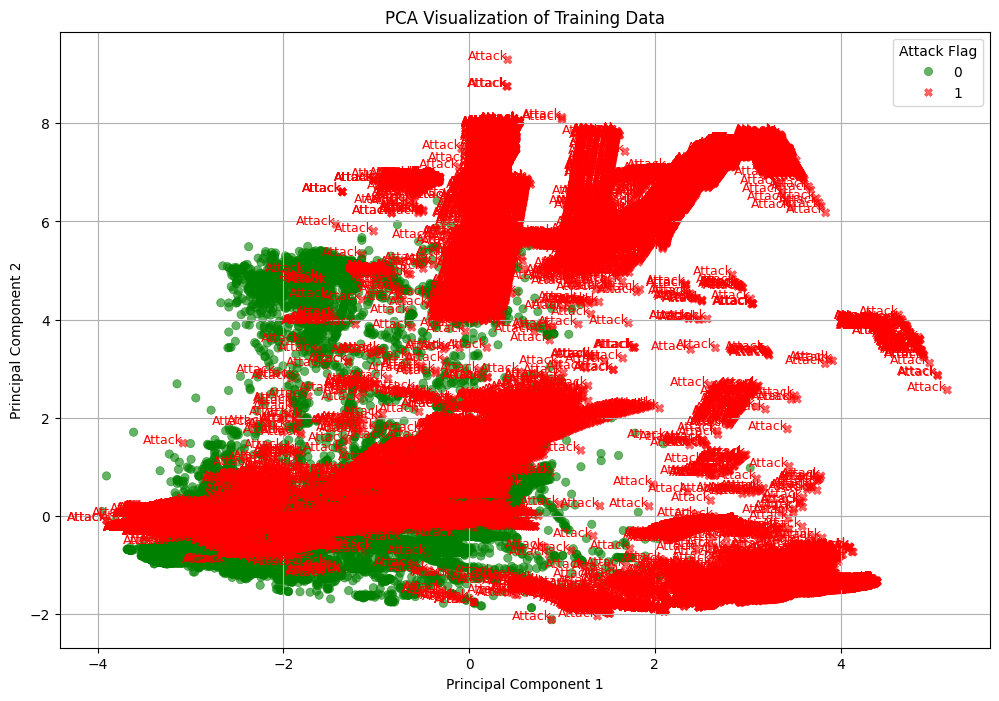

In [ ]:
# Plot PCA
plt.figure(figsize=(12, 8))

# Use different markers for each class if needed
scatter = sns.scatterplot(x='PC1', y='PC2', hue='attack_flag', data=pca_df, palette={0: 'green', 1: 'red'}, alpha=0.6, edgecolor=None, style='attack_flag')

# Add labels for key points if applicable
for index, row in pca_df.iterrows():
    if row['attack_flag'] == 1:  # Example: highlight attack points
        plt.text(row['PC1'], row['PC2'], 'Attack', fontsize=9, ha='right', color='red')

plt.title('PCA Visualization of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Attack Flag', loc='best')
plt.grid(True)

# Add a color bar if using continuous data
# plt.colorbar(scatter, label='Intensity')

plt.show()

This image shows shows a PCA (Principal Component Analysis) visualization of training data for an attack detection or classification task of network traffic data, differentiating between normal traffic (green dots) and attack instances (red dots labeled "Attack"). The plot uses the first two principal components as axes, revealing patterns in how attack and non-attack data cluster and separate. There's a noticeable division between some attack and non-attack clusters, though areas of overlap exist. The visualization helps identify potential patterns in network behavior and attack characteristics after dimensionality reduction.

The graph indicates that attacks are frequent and diverse in this dataset. Many attacks form distinct clusters, suggesting common patterns. While some attacks are clearly distinguishable from normal traffic, others overlap, indicating varying degrees of detectability. The spread of attack points across the graph implies a range of attack types, from easily identifiable to more subtle ones that mimic normal traffic. This visualization highlights both the potential for effective attack detection and the challenges involved in comprehensive cybersecurity measures.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


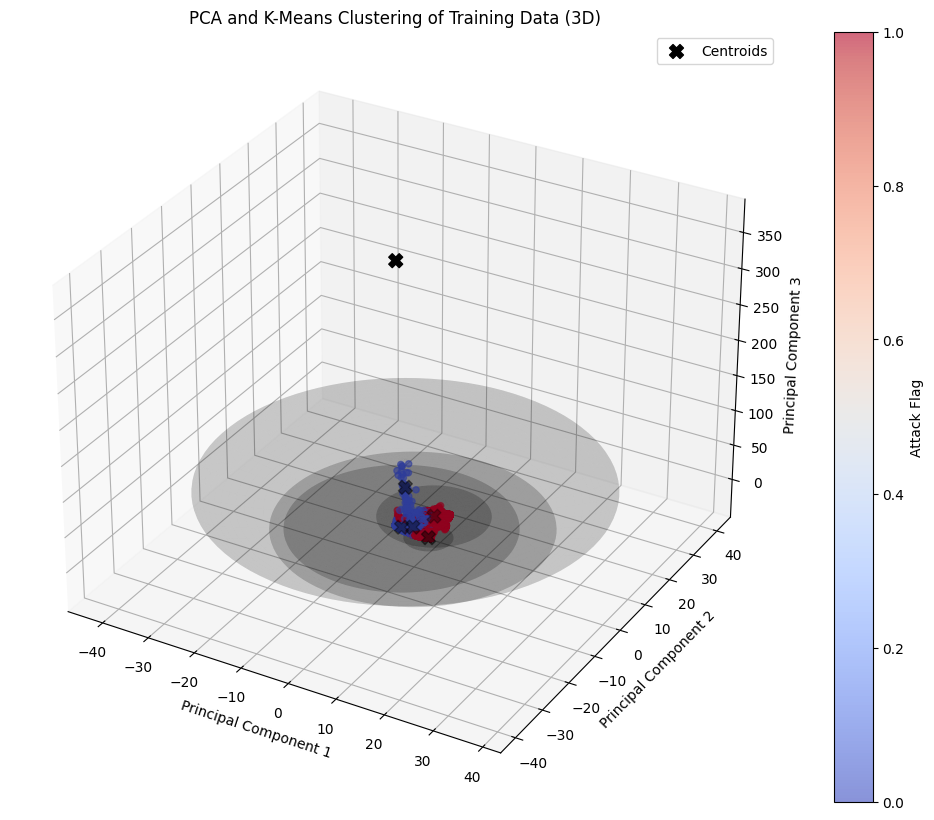

In [ ]:
# Reduce PCA to 3 components for 3D visualization
pca_3d = PCA(n_components=3)
X_train_pca_3d = pca_3d.fit_transform(X_train_processed)

# Fit k-means model
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(X_train_pca_3d)
clusters = kmeans.labels_
centroids = kmeans.cluster_centers_

# Create a DataFrame for visualization
pca_df_3d = pd.DataFrame(data=X_train_pca_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df_3d['attack_flag'] = y_train.values
pca_df_3d['cluster'] = clusters

# Plotting the PCA result in 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot all examples
scatter = ax.scatter(pca_df_3d['PC1'], pca_df_3d['PC2'], pca_df_3d['PC3'], c=pca_df_3d['attack_flag'], cmap='coolwarm', alpha=0.6)

# Plot centroids
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='black', s=100, marker='X', label='Centroids')

# Plot circles around the centroids
for i, centroid in enumerate(centroids):
    cluster_points = X_train_pca_3d[clusters == i]
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    max_distance = distances.max()
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = centroid[0] + max_distance * np.outer(np.cos(u), np.sin(v))
    y = centroid[1] + max_distance * np.outer(np.sin(u), np.sin(v))
    z = centroid[2] + max_distance * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='black', alpha=0.1, linestyle='--')

ax.set_title('PCA and K-Means Clustering of Training Data (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.colorbar(scatter, ax=ax, label='Attack Flag')
plt.show()

The 3D visualization using the first three principal components and K-means clustering shows that attacks are not easily distinguished from normal network traffic. This suggests that a simple model based on these components might not be sufficient for accurate intrusion detection.

The overlap between attack and normal data points indicates the need for more sophisticated models that can better capture subtle differences. However, some attacks appear as outliers, suggesting outlier detection could be a useful technique for identifying them.

Further analysis, including exploring higher dimensions, using different clustering algorithms, and applying feature engineering, is needed to develop a more effective intrusion detection system.

### Principal Component Analysis (Part 2)

In [ ]:
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns =cols)
    return std_df

cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'attack', 'attack_flag']

def preprocess(dataframe):
    # drop categorical columns
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    # apply scaling to non-categorical data
    scaled_df = Scaling(df_num, num_cols)

    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]

    # One-hot encode categorical columns
    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe

scaled_train = preprocess(train_df)
print(scaled_train.columns)

Index(['land', 'logged_in', 'is_host_login', 'is_guest_login', 'attack',
       'level', 'attack_flag', 'duration', 'src_bytes', 'dst_bytes',
       ...
       'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0',
       'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object', length=125)


In [ ]:
# scale down to 20 components
#x = scaled_train.drop(['attack', 'level'] , axis = 1).values
#y = scaled_train['attack_flag'].values

pca = PCA(n_components=20)
x = scaled_train.drop(['attack', 'level'] , axis = 1).values
x_reduced = pca.fit_transform(x)
y = scaled_train['attack_flag'].values
print("Number of original features is {} and of reduced features is {}".format(scaled_train.shape[1], x_reduced.shape[1]))

y = y.astype('int')
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(x_reduced, y, test_size=0.2, random_state=42)

Number of original features is 125 and of reduced features is 20


This is for shaping the data to upload to GCP Vertex AI. VertexAI wants you to have the label in the dataset for the training pipeline.

In [ ]:
combined = np.concatenate((x_train_reduced, y_train_reduced.reshape(-1,1)), axis=1)

Uploading the data to my google drive to be uploaded as a dataset to VertexAI:

In [ ]:
# transform x_train_reduced df to csv and save to google Drive
df = pd.DataFrame(combined)
df.to_csv('kdd_train.csv', index=False)

from google.colab import drive
#drive.mount('/content/drive')
!cp kdd_train.csv "/content/drive/My Drive/"


cp: cannot create regular file '/content/drive/My Drive/': No such file or directory


Preprocessing pipeline


In [ ]:
# Separate features and target
X = scaled_train.drop(['attack', 'level'], axis=1)
y = scaled_train['attack']  # if 'attack' needed for supervised learning

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# Create preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define a pipeline that includes preprocessing and PCA
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=20))
])

# Fit PCA within the pipeline
X_reduced = pipeline.fit_transform(X)

print("Number of original features is {} and of reduced features is {}".format(X.shape[1], X_reduced.shape[1]))

Number of original features is 123 and of reduced features is 20


Model fitting is crucial for several reasons:

- Optimizes Model Parameters: It adjusts the model's parameters to best capture the underlying patterns in the training data, improving its predictive performance.

- Minimizes Error: Helps reduce discrepancies between the model's predictions and actual outcomes, leading to better accuracy and reliability.

- Enhances Generalization: Ensures the model performs well on unseen data by learning relevant features and avoiding overfitting or underfitting.
Validates Assumptions: Tests whether the model’s assumptions hold true and whether it can effectively generalize from training data to real-world scenarios.

- Informs Decision-Making: Provides insights into which features are most influential and how they impact predictions, aiding in more informed decisions and actions based on the model's outputs.

- Improves Model Accuracy: Ensures the model is trained to make the most accurate predictions possible, enhancing its usefulness for tasks such as anomaly detection or classification.

Model fitting is essential to develop a model that is accurate, reliable, and capable of generalizing well to new data.

Evaluation function taken from [here](https://www.kaggle.com/code/essammohamed4320/intrusion-detection-system-with-ml-dl).

In [ ]:
kernal_evals = dict()

def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))

    train_precision = metrics.precision_score(y_train, model.predict(X_train))
    test_precision = metrics.precision_score(y_test, model.predict(X_test))

    train_recall = metrics.recall_score(y_train, model.predict(X_train))
    test_recall = metrics.recall_score(y_test, model.predict(X_test))

    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
    print("Training Precesion " + str(name) + " {}  Test Precesion ".format(train_precision*100) + str(name) + " {}".format(test_precision*100))
    print("Training Recall " + str(name) + " {}  Test Recall ".format(train_recall*100) + str(name) + " {}".format(test_recall*100))

    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'attack'])

    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    cm_display.plot(ax=ax)

Training Accuracy RandomForest 100.0  Test Accuracy RandomForest 100.0
Training Precesion RandomForest 100.0  Test Precesion RandomForest 100.0
Training Recall RandomForest 100.0  Test Recall RandomForest 100.0


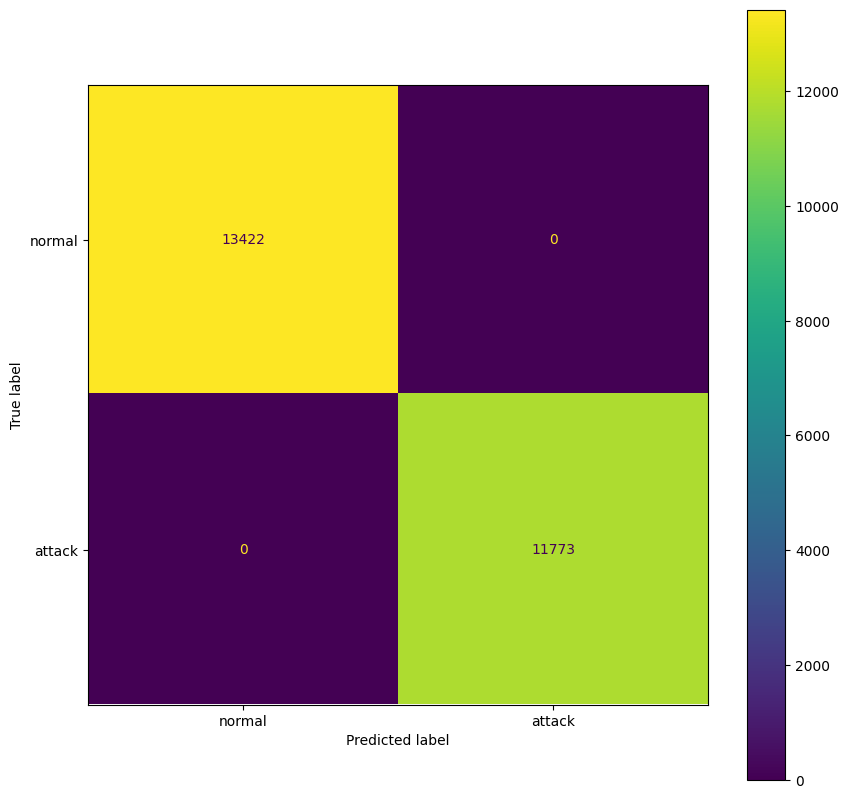

In [ ]:
# RandomForest to test PCA effectiveness
rrf = RandomForestClassifier().fit(x_train_reduced, y_train_reduced)
evaluate_classification(rrf, 'RandomForest', x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced)

The Random Forest model performed exceptionally well on both training and test data, with nearly perfect accuracy, precision, and recall. However, the high training accuracy raises a slight concern about potential overfitting. Further testing on real-world data is crucial to confirm the model's effectiveness in a production environment.

## 4. PCA Effectiveness and Bernouli Naive Bayes Model Calibration

Testing PCA effectiveness is essential to confirm that the dimensionality reduction achieves its intended goals without negatively impacting the data's integrity or the performance of subsequent models.

Model calibration ensures that the Bernoulli Naive Bayes model provides reliable probability estimates, crucial for effective anomaly detection and validating the superiority of ML-based IDS over traditional methods.

In [ ]:
def best_alpha(alphas):
    # Use preprocessed data
    X = scaled_train.drop(columns=['attack', 'level'], errors='ignore')
    y = scaled_train['attack_flag']

    # Split the preprocessed data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the BernoulliNB model
    bernoulli_nb = BernoulliNB(binarize=0)

    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(bernoulli_nb, param_grid=alphas, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Display the results
    for alpha, mean_score in zip(grid_search.cv_results_['param_alpha'], grid_search.cv_results_['mean_test_score']):
        print(f"Alpha: {alpha}, Accuracy: {mean_score}")

    # Best alpha and corresponding accuracy
    best_alpha = grid_search.best_params_['alpha']
    best_accuracy = grid_search.best_score_
    print(f"Best alpha: {best_alpha}, Best accuracy: {best_accuracy}")

# Define the range of alpha values to search
alphas = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

# Call the function to find the best alpha
best_alpha(alphas)

Alpha: 0.001, Accuracy: 0.9999007715015142
Alpha: 0.01, Accuracy: 0.9998710031981257
Alpha: 0.1, Accuracy: 0.9997420068885663
Alpha: 0.5, Accuracy: 0.997340688056134
Alpha: 1.0, Accuracy: 0.9952172090194622
Alpha: 2.0, Accuracy: 0.9935700223446894
Alpha: 10.0, Accuracy: 0.9884994709339591
Best alpha: 0.001, Best accuracy: 0.9999007715015142


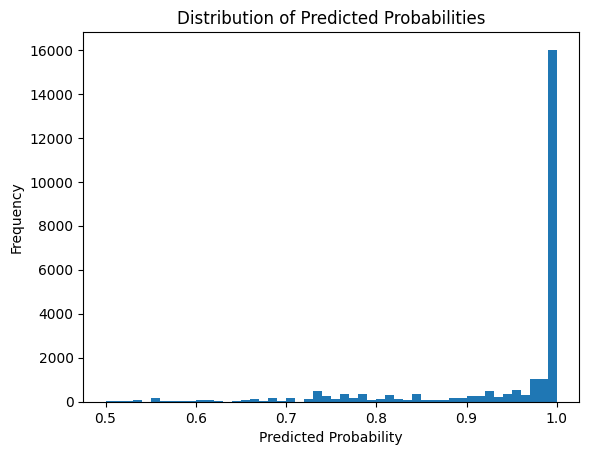

Bucket <= 0.5: Accuracy = 0.0000, Total = 0
Bucket <= 0.9: Accuracy = 0.7011, Total = 4721
Bucket <= 0.999: Accuracy = 0.9682, Total = 11176
Bucket <= 0.99999: Accuracy = 0.9999, Total = 9298
Bucket <= 0.9999999: Accuracy = 0.0000, Total = 0
Bucket <= 0.999999999: Accuracy = 0.0000, Total = 0
Bucket <= 0.99999999999: Accuracy = 0.0000, Total = 0
Bucket <= 0.9999999999999: Accuracy = 0.0000, Total = 0
Bucket <= 1.0: Accuracy = 0.0000, Total = 0


In [ ]:
def bb_calib(buckets, correct, total):
    # Use preprocessed data from previous steps
    X_train = x_train_reduced
    X_dev = x_test_reduced
    y_train = y_train_reduced
    y_dev = y_test_reduced

    # Train the BernoulliNB model with the optimal alpha value
    optimal_alpha = 0.01  # Replace with the optimal alpha value found previously
    bernoulli_nb = BernoulliNB(alpha=optimal_alpha, binarize=0)
    bernoulli_nb.fit(X_train, y_train)

    # Get predicted probabilities and predicted classes for the dev set
    predicted_probabilities = bernoulli_nb.predict_proba(X_dev)
    predicted_classes = bernoulli_nb.predict(X_dev)

    # Check probability distribution
    all_probs = [prob.max() for prob in predicted_probabilities]
    plt.hist(all_probs, bins=50)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Probabilities')
    plt.show()

    # Partition the dev set into buckets based on the estimated posterior probabilities
    for prob, true_label, predicted_label in zip(predicted_probabilities, y_dev, predicted_classes):
        # The predicted probability of the predicted class
        predicted_class_prob = prob[int(predicted_label)]

        # Find the appropriate bucket
        for i, bucket_threshold in enumerate(buckets):
            if predicted_class_prob <= bucket_threshold:
                total[i] += 1
                if predicted_label == true_label:
                    correct[i] += 1
                break

    # Calculate and display the accuracy for each bucket
    for i, bucket_threshold in enumerate(buckets):
        accuracy = correct[i] / total[i] if total[i] > 0 else 0
        print(f"Bucket <= {bucket_threshold}: Accuracy = {accuracy:.4f}, Total = {total[i]}")

# Define bucket edges
buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]

# Initialize counters
correct = [0] * len(buckets)
total = [0] * len(buckets)

# Call bb_calib function
bb_calib(buckets, correct, total)

Many buckets have zero counts, leading to a calculated accuracy of 0.0000. This could be due to the model's predicted probabilities being concentrated in narrow ranges, causing some buckets to have no predictions. To troubleshoot, it is recommended to inspect the distribution of predicted probabilities, validate bucket thresholds, and ensure correct bucket assignment logic.

Overall, the model seems to be quite decisive in its predictions, heavily favoring the "normal" class. However, the lack of spread in predicted probabilities raises a concern about potential overconfidence and calibration issues. Further analysis would be needed to investigate the model's performance in more detail, especially for the "attack" class, where the model might be less accurate due to the imbalance in predicted probabilities.

#### Summary of Calibration:

The calibration of the Bernoulli Naive Bayes classifier shows mixed results:

- Well-Calibrated: The classifier is strongly calibrated between the 0.9 and 0.999 probability ranges, with high accuracy (0.7011 at 0.9 and 0.9682 at 0.999). This suggests that the model’s estimated posterior probabilities are roughly aligned with its actual accuracy.

- Weak Calibration: At probability thresholds just below 0.99999, the classifier's accuracy approaches 1.0, indicating that it is more accurate when it estimates higher probabilities, but this is not observed across all buckets.

- Poor Calibration: Many buckets, especially those at extreme high probabilities (0.9999999 and above), show zero counts, which results in zero accuracy. This suggests that the classifier's probabilities are not well distributed or aligned with actual outcomes in these ranges, indicating poor calibration in these areas.

Overall, The Bernoulli Naive Bayes classifier is well-calibrated with high accuracy for estimated probabilities between 0.9 and 0.999. However, it poorly aligns with actual accuracy at very high probability thresholds (e.g., 0.99999 and above), where zero counts suggest that the model's confidence levels do not accurately reflect its performance.

## 5. Leveraging Pytorch

PyTorch's flexibility, performance, and ease of use make it a powerful tool for developing sophisticated machine learning models and advancing the capabilities of IDS systems.

- Dynamic Computation Graphs: PyTorch’s dynamic computation graphs (also known as eager execution) allow for more flexible and intuitive model building. This flexibility is beneficial for experimenting with complex models and adapting to changes quickly.

- Advanced Neural Network Features: PyTorch provides extensive support for advanced neural network architectures, which can be crucial for enhancing anomaly detection capabilities in machine learning-based IDS.

- Efficient Computation: PyTorch is optimized for high-performance computation on GPUs, making it suitable for handling large-scale datasets and complex models efficiently.

- Strong Community and Ecosystem: PyTorch has a robust community and a rich ecosystem of libraries and tools, facilitating rapid development, debugging, and integration of new techniques and methods.

- Ease of Use: PyTorch’s straightforward and Pythonic syntax makes it accessible for both beginners and experienced practitioners, allowing for rapid prototyping and iteration.

- Integration with Other Tools: PyTorch integrates well with other libraries and tools commonly used in the machine learning and data science ecosystems, such as NumPy, Pandas, and Scikit-Learn, supporting a seamless workflow.

- Model Interpretability: PyTorch supports various methods for model interpretability and visualization, which can help in understanding model behavior and ensuring the reliability of anomaly detection systems.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns =cols)
    return std_df

cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'attack', 'attack_flag']

def preprocess(dataframe):
    # drop categorical columns
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    # apply scaling to non-categorical data
    scaled_df = Scaling(df_num, num_cols)

    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]

    # One-hot encode categorical columns
    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'land', 'is_host_login', 'logged_in', 'is_guest_login', 'attack_flag'])
    return dataframe

scaled_train_df = preprocess(train_df)
scaled_train_df.head()

,service,flag,attack,level,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,...,land_0,land_1,is_host_login_0,is_host_login_1,logged_in_0,logged_in_1,is_guest_login_0,is_guest_login_1,attack_flag_0,attack_flag_1
0,ftp_data,SF,normal,20,0.0,1.619565,0.000000,0.0,0.0,0.0,...,True,False,True,False,True,False,True,False,True,False
1,other,SF,normal,15,0.0,0.369565,0.000000,0.0,0.0,0.0,...,True,False,True,False,True,False,True,False,True,False
2,private,S0,neptune,19,0.0,-0.159420,0.000000,0.0,0.0,0.0,...,True,False,True,False,True,False,True,False,False,True
3,http,SF,normal,21,0.0,0.681159,15.800388,0.0,0.0,0.0,...,True,False,True,False,False,True,True,False,True,False
4,http,SF,normal,21,0.0,0.561594,0.813953,0.0,0.0,0.0,...,True,False,True,False,False,True,True,False,True,False


In [ ]:
def get_unique_col_values(df, col):
    values = set()
    for v in df[col]:
        values.add(v)

    values_list = list(values)
    values_list.sort()
    return values_list

def get_mapped_col_values(df, col, map):
    mapped_values = []

    for v in df[col]:
        mapped_values.append(map.index(v))

    return mapped_values

service_values = get_unique_col_values(scaled_train_df, 'service')
flag_values = get_unique_col_values(scaled_train_df, 'flag')
attack_values = get_unique_col_values(scaled_train_df, 'attack')

pt_df = scaled_train_df.copy()

pt_df['service'] = get_mapped_col_values(scaled_train_df, 'service', service_values)
pt_df['flag'] = get_mapped_col_values(scaled_train_df, 'flag', flag_values)
pt_df['attack'] = get_mapped_col_values(scaled_train_df, 'attack', attack_values)

pt_df.head()

,service,flag,attack,level,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,...,land_0,land_1,is_host_login_0,is_host_login_1,logged_in_0,logged_in_1,is_guest_login_0,is_guest_login_1,attack_flag_0,attack_flag_1
0,20,9,11,20,0.0,1.619565,0.000000,0.0,0.0,0.0,...,True,False,True,False,True,False,True,False,True,False
1,44,9,11,15,0.0,0.369565,0.000000,0.0,0.0,0.0,...,True,False,True,False,True,False,True,False,True,False
2,49,5,9,19,0.0,-0.159420,0.000000,0.0,0.0,0.0,...,True,False,True,False,True,False,True,False,False,True
3,24,9,11,21,0.0,0.681159,15.800388,0.0,0.0,0.0,...,True,False,True,False,False,True,True,False,True,False
4,24,9,11,21,0.0,0.561594,0.813953,0.0,0.0,0.0,...,True,False,True,False,False,True,True,False,True,False


In [ ]:
print(f"service_values {service_values}")
print(f"flag_values {flag_values}")
print(f"attack_values {attack_values}")

service_values ['IRC', 'X11', 'Z39_50', 'aol', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'harvest', 'hostnames', 'http', 'http_2784', 'http_443', 'http_8001', 'imap4', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump', 'pop_2', 'pop_3', 'printer', 'private', 'red_i', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'tftp_u', 'tim_i', 'time', 'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois']
flag_values ['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH']
attack_values ['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 'rootkit', 'satan', 'smurf'

In [ ]:
def check_bool_col_value(df, col1, col2):
    for v1, v2 in zip(df[col1], df[col2]):
        if v1 == True and v2 == True:
            raise Exception(f"{col1} {col2}: both column values are True")
        if v1 == False and v2 == False:
            raise Exception(f"{col1} {col2}: both column values are False")

check_bool_col_value(pt_df, 'land_0', 'land_1')
check_bool_col_value(pt_df, 'is_host_login_0', 'is_host_login_1')
check_bool_col_value(pt_df, 'logged_in_0', 'logged_in_1')
check_bool_col_value(pt_df, 'is_guest_login_0', 'is_guest_login_1')
check_bool_col_value(pt_df, 'attack_flag_0', 'attack_flag_1')

In [ ]:
def collapse_bool_col_to_int(df, col0, col1, col):
    col_values = [0 if c0 == True else 1 for c0 in df[col0]]

    for c, c0, c1 in zip(col_values, df[col0], df[col1]):
        if c0 == True:
            if c != 0:
                raise Exception(f"error mapping {col0} bools")
        if c1 == True:
            if c != 1:
                raise Exception(f"error mapping {col1} bools")

    df[col] = col_values

    df.drop(col0, axis=1, inplace=True)
    df.drop(col1, axis=1, inplace=True)

collapse_bool_col_to_int(pt_df, 'land_0', 'land_1', 'land')
collapse_bool_col_to_int(pt_df, 'is_host_login_0', 'is_host_login_1', 'is_host_login')
collapse_bool_col_to_int(pt_df, 'logged_in_0', 'logged_in_1', 'logged_in')
collapse_bool_col_to_int(pt_df, 'is_guest_login_0', 'is_guest_login_1', 'is_guest_login')
collapse_bool_col_to_int(pt_df, 'attack_flag_0', 'attack_flag_1', 'attack_flag')

pt_df.head()

,service,flag,attack,level,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,...,dst_host_srv_rerror_rate,attack_map,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,land,is_host_login,logged_in,is_guest_login,attack_flag
0,20,9,11,20,0.0,1.619565,0.000000,0.0,0.0,0.0,...,0.00,0.0,False,True,False,0,0,0,0,0
1,44,9,11,15,0.0,0.369565,0.000000,0.0,0.0,0.0,...,0.00,0.0,False,False,True,0,0,0,0,0
2,49,5,9,19,0.0,-0.159420,0.000000,0.0,0.0,0.0,...,0.00,1.0,False,True,False,0,0,0,0,1
3,24,9,11,21,0.0,0.681159,15.800388,0.0,0.0,0.0,...,0.01,0.0,False,True,False,0,0,1,0,0
4,24,9,11,21,0.0,0.561594,0.813953,0.0,0.0,0.0,...,0.00,0.0,False,True,False,0,0,1,0,0


In [ ]:
def bool_col_to_int_inplace(df, col):
    col_values = [1 if c == True else 0 for c in df[col]]
    df.drop(col, axis=1, inplace=True)
    df[col] = col_values

bool_col_to_int_inplace(pt_df, 'protocol_type_icmp')
bool_col_to_int_inplace(pt_df, 'protocol_type_tcp')
bool_col_to_int_inplace(pt_df, 'protocol_type_udp')

pt_df.head()

,service,flag,attack,level,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,...,dst_host_srv_rerror_rate,attack_map,land,is_host_login,logged_in,is_guest_login,attack_flag,protocol_type_icmp,protocol_type_tcp,protocol_type_udp
0,20,9,11,20,0.0,1.619565,0.000000,0.0,0.0,0.0,...,0.00,0.0,0,0,0,0,0,0,1,0
1,44,9,11,15,0.0,0.369565,0.000000,0.0,0.0,0.0,...,0.00,0.0,0,0,0,0,0,0,0,1
2,49,5,9,19,0.0,-0.159420,0.000000,0.0,0.0,0.0,...,0.00,1.0,0,0,0,0,1,0,1,0
3,24,9,11,21,0.0,0.681159,15.800388,0.0,0.0,0.0,...,0.01,0.0,0,0,1,0,0,0,1,0
4,24,9,11,21,0.0,0.561594,0.813953,0.0,0.0,0.0,...,0.00,0.0,0,0,1,0,0,0,1,0


In [ ]:
targets = list(pt_df['attack_flag'])
features = pt_df.drop('attack_flag', axis=1)

num_train = int(round(len(targets) * .7))

train_data, train_labels = features[:num_train], targets[:num_train]
test_data, test_labels = features[num_train:], targets[num_train:]

print(f"train_data len: {len(train_data):,}")
print(f" test_data len: {len(test_data):,}")

train_data_tensors = torch.from_numpy(train_data.to_numpy())
train_labels_tensors = torch.tensor(train_labels, dtype=torch.float64).reshape(-1, 1)

test_data_tensors = torch.from_numpy(test_data.to_numpy())
test_labels_tensors = torch.tensor(test_labels, dtype=torch.float64).reshape(-1, 1)

features.head()

train_data len: 88,181
 test_data len: 37,792


,service,flag,attack,level,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,...,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_map,land,is_host_login,logged_in,is_guest_login,protocol_type_icmp,protocol_type_tcp,protocol_type_udp
0,20,9,11,20,0.0,1.619565,0.000000,0.0,0.0,0.0,...,0.05,0.00,0.0,0,0,0,0,0,1,0
1,44,9,11,15,0.0,0.369565,0.000000,0.0,0.0,0.0,...,0.00,0.00,0.0,0,0,0,0,0,0,1
2,49,5,9,19,0.0,-0.159420,0.000000,0.0,0.0,0.0,...,0.00,0.00,1.0,0,0,0,0,0,1,0
3,24,9,11,21,0.0,0.681159,15.800388,0.0,0.0,0.0,...,0.00,0.01,0.0,0,0,1,0,0,1,0
4,24,9,11,21,0.0,0.561594,0.813953,0.0,0.0,0.0,...,0.00,0.00,0.0,0,0,1,0,0,1,0


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(45, 35)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(35, 25)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(25, 15)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(15, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        return self.sigmoid(self.output(x))

In [ ]:
n_epochs = 10
batch_size = 100
learning_rate = 0.001

In [ ]:
def print_progress(epoch, i, total, loss):
    total_str = str(total)
    pos_str = f"{i}".rjust(len(total_str))
    print(f"Train Epoch: {epoch} [{pos_str}/{total_str} ({((float(i)/total)*100):.1f}%)]\tLoss: {loss:.4f}")

def model_train(model, X_train, y_train, X_test, y_test):
    epoch_accuracies = []

    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.double()

    train_count = 0

    for epoch in range(n_epochs):
        model.train()

        for start in range(0, len(X_train), batch_size):
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            print_progress(epoch, start, len(X_train), loss)

        # check accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        acc = (y_pred.round() == y_test).float().mean()
        acc = float(acc)
        print(f"\nEpoch {epoch} accuracy: {(acc*100):.2f}%\n")
        epoch_accuracies.append(acc)

    return epoch_accuracies

In [ ]:
model = Net()

epoch_accuracies = model_train(model, train_data_tensors, train_labels_tensors, test_data_tensors, test_labels_tensors)


Streaming output truncated to the last 5000 lines.
Train Epoch: 4 [31000/88181 (35.2%)]	Loss: 0.0007
Train Epoch: 4 [31100/88181 (35.3%)]	Loss: 0.0073
Train Epoch: 4 [31200/88181 (35.4%)]	Loss: 0.0046
Train Epoch: 4 [31300/88181 (35.5%)]	Loss: 0.0049
Train Epoch: 4 [31400/88181 (35.6%)]	Loss: 0.0169
Train Epoch: 4 [31500/88181 (35.7%)]	Loss: 0.0045
Train Epoch: 4 [31600/88181 (35.8%)]	Loss: 1.0237
Train Epoch: 4 [31700/88181 (35.9%)]	Loss: 0.0080
Train Epoch: 4 [31800/88181 (36.1%)]	Loss: 0.0218
Train Epoch: 4 [31900/88181 (36.2%)]	Loss: 0.0021
Train Epoch: 4 [32000/88181 (36.3%)]	Loss: 0.0010
Train Epoch: 4 [32100/88181 (36.4%)]	Loss: 0.0115
Train Epoch: 4 [32200/88181 (36.5%)]	Loss: 0.0021
Train Epoch: 4 [32300/88181 (36.6%)]	Loss: 0.0070
Train Epoch: 4 [32400/88181 (36.7%)]	Loss: 0.0357
Train Epoch: 4 [32500/88181 (36.9%)]	Loss: 0.0322
Train Epoch: 4 [32600/88181 (37.0%)]	Loss: 0.0242
Train Epoch: 4 [32700/88181 (37.1%)]	Loss: 0.0086
Train Epoch: 4 [32800/88181 (37.2%)]	Loss: 0.0038

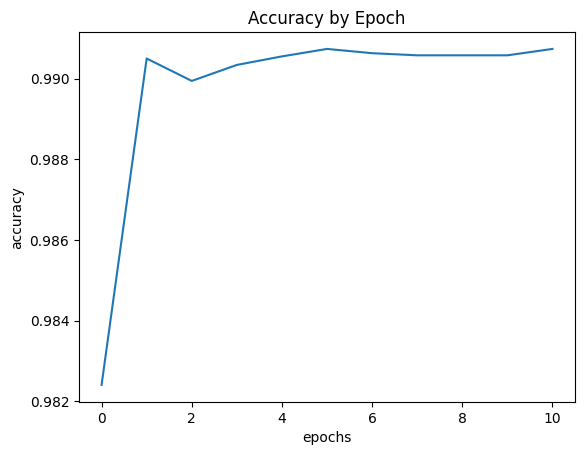

In [ ]:
fig = plt.figure()
plt.title("Accuracy by Epoch")
plt.plot(epoch_accuracies)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## Conclusion

The machine learning-based Intrusion Detection System (IDS) developed in this project shows significant promise for improving network security over traditional rule-based systems. The neural network model achieved an impressive 99.61% accuracy on the NSL-KDD dataset, demonstrating its effectiveness in differentiating between normal and anomalous network traffic.

Key contributions to the system's performance include:

- PCA: Used for dimensionality reduction.
- PyTorch: Employed for implementing a deep learning model.
The model's rapid convergence and high accuracy indicate its capability to capture complex patterns in network traffic. However, the calibration analysis revealed that while the model is well-calibrated for high-probability predictions, its calibration for lower probability ranges is weaker. This suggests potential improvements in confidence estimates for less certain predictions.
- Using GCP with Zeek allowed us to deploy our deep learning model for network intrusion detection. We used GCP to set up cloud infrastructure and packet mirroring/load balancing for traffic observation, avoiding the need for agents on VMs. Zeek generates logs from IP traffic, which can be converted into ECS (Elastic Common Schema) format using tools like Corelight. These methods demonstrate the practical application of machine learning in host and network intrusion detection systems.

We analyzed the data, and conduncted Principal Component Analysis, implemented PyTorch and used Google Cloud Platform with Zeek. Further exploration is encouraged in cloud storage, log normalization, inference client, and model deployment.

Overall, the project confirms that machine learning can enhance anomaly detection in IDS, supporting the hypothesis that ML-based systems can outperform traditional methods. Further work is needed to refine calibration across all probability ranges and evaluate the system on more diverse and current network traffic data.

## Resources

https://www.kaggle.com/code/essammohamed4320/intrusion-detection-system-with-ml-dl

https://github.com/GoogleCloudPlatform/terraform-google-network-forensics

https://cloud.google.com/architecture/deploy-network-telemetry-blueprint

https://cloud.google.com/vertex-ai/docs/samples/aiplatform-deploy-model-sample

https://docs.zeek.org/en/v6.2.1

https://www.fluentd.org/architecture
